In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

In [2]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [3]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

2024-03-28 21:28:09.523395: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-03-28 21:28:09.523411: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-28 21:28:09.523414: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-28 21:28:09.523448: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-28 21:28:09.523459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [5]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [6]:
train_images.as_numpy_iterator().next()

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.00784314, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.00784314, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.01029412, 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']
# Setting the shapes explicitly
def set_shapes(cat_label, float_label):
    cat_label.set_shape([1])
    float_label.set_shape([4])
    return cat_label, float_label



In [8]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
# Applying the set_shapes function to each element in the dataset
train_labels = train_labels.map(set_shapes)

test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = test_labels.map(set_shapes)

val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = val_labels.map(set_shapes)
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.    , 0.    , 0.2476, 0.506 ], dtype=float16))

In [9]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2700, 2700, 600, 600, 600, 600)

In [10]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [11]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)


In [12]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [13]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.1399, 0.7935],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.8096, 0.819 ]], dtype=float16))

In [14]:
data_samples = train.as_numpy_iterator()

In [15]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


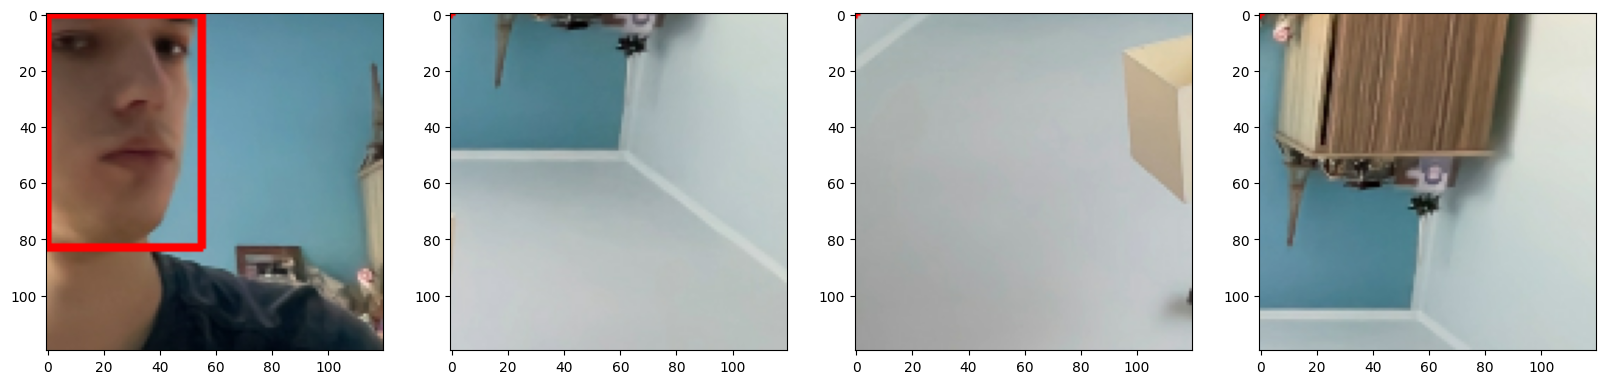

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [18]:
vgg = VGG16(include_top=False)

In [19]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [21]:
facetracker = build_model()

In [22]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
X, y = train.as_numpy_iterator().next()

In [24]:
X.shape

(8, 120, 120, 3)

In [25]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


2024-03-28 21:28:17.492597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [26]:
classes, coords

(array([[0.5331081 ],
        [0.4811003 ],
        [0.51623636],
        [0.42507416],
        [0.375773  ],
        [0.38208106],
        [0.4688501 ],
        [0.4259608 ]], dtype=float32),
 array([[0.38316706, 0.3953855 , 0.72389334, 0.52600634],
        [0.35027552, 0.34447148, 0.7296951 , 0.57895124],
        [0.33754995, 0.3341796 , 0.7056716 , 0.5859045 ],
        [0.42155835, 0.39011768, 0.7396768 , 0.55966187],
        [0.44698602, 0.4908288 , 0.68992454, 0.55834174],
        [0.36244652, 0.46167606, 0.7252258 , 0.5269751 ],
        [0.41588902, 0.38104734, 0.70718354, 0.5655975 ],
        [0.28791955, 0.45185483, 0.71950674, 0.57038623]], dtype=float32))

In [27]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [28]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# Now, use this learning rate schedule in the Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [29]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [30]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [31]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.305071>

In [32]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.76554835>

In [33]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.305071>

In [34]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [35]:
model = FaceTracker(facetracker)

In [36]:
model.compile(opt, classloss, regressloss)

In [37]:
logdir='logs'

In [38]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2024-03-28 21:28:22.050791: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:580 : NOT_FOUND: could not find registered platform with id: 0x3138d0460
2024-03-28 21:28:22.050807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: NOT_FOUND: could not find registered platform with id: 0x3138d0460
	 [[{{function_node __inference_one_step_on_data_47014}}{{node functional_1_1/vgg16_1/block1_conv1_1/StatefulPartitionedCall}}]]


NotFoundError: Graph execution error:

Detected at node functional_1_1/vgg16_1/block1_conv1_1/StatefulPartitionedCall defined at (most recent call last):
  File "/opt/anaconda3/envs/tensor/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/anaconda3/envs/tensor/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/anaconda3/envs/tensor/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/anaconda3/envs/tensor/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/anaconda3/envs/tensor/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/pz/zkbcmpks3m370hyv10zy19z00000gn/T/ipykernel_1931/2029832520.py", line 1, in <module>

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 118, in one_step_on_iterator

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 106, in one_step_on_data

  File "/var/folders/pz/zkbcmpks3m370hyv10zy19z00000gn/T/ipykernel_1931/3808712638.py", line 17, in train_step

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/layers/layer.py", line 814, in __call__

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/models/functional.py", line 194, in call

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/ops/function.py", line 151, in _run_through_graph

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/models/functional.py", line 578, in call

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/layers/layer.py", line 814, in __call__

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/models/functional.py", line 194, in call

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/ops/function.py", line 151, in _run_through_graph

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/models/functional.py", line 578, in call

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/layers/layer.py", line 814, in __call__

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 224, in call

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 214, in convolution_op

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/ops/nn.py", line 909, in conv

  File "/opt/anaconda3/envs/tensor/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 278, in conv

could not find registered platform with id: 0x3138d0460
	 [[{{node functional_1_1/vgg16_1/block1_conv1_1/StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_47227]